# 选股宝概念股数据分析

> 数据来源：选股宝 (xuangubao.cn) 概念板块数据库  
> 分析日期：2026-02-28

本笔记本对选股宝概念股数据库进行全面分析，涵盖：
1. 概念板块分布与统计
2. 板块涨跌幅与资金流向
3. 个股与概念的关联映射
4. 产业链结构分析
5. 龙头股筛选
6. 可视化仪表盘汇总

## 1. 导入所需库并配置环境

In [17]:
import sqlite3
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import Counter

# ── 中文字体配置 ──
# macOS 优先使用 PingFang SC，备选 Heiti SC / STHeiti
for font in ["PingFang SC", "Heiti SC", "STHeiti", "SimHei", "Arial Unicode MS"]:
    try:
        matplotlib.font_manager.FontProperties(fname=font)
        plt.rcParams["font.sans-serif"] = [font, "DejaVu Sans"]
        break
    except Exception:
        continue
plt.rcParams["axes.unicode_minus"] = False

# ── 样式与显示配置 ──
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 80)
warnings.filterwarnings("ignore")

# ── 输出目录 ──
OUTPUT_DIR = os.path.join(os.path.dirname(os.path.abspath(".")), "ipynb", "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"输出目录: {OUTPUT_DIR}")
print("环境配置完成 ✓")

输出目录: /Users/xingkong/Desktop/llm-benchmark-2-news/ipynb/output
环境配置完成 ✓


## 2. 连接数据库并加载数据

In [18]:
DB_PATH = "../data/xuangubao.db"
conn = sqlite3.connect(DB_PATH)

# 列出所有表
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("数据库中的表：")
print(tables["name"].tolist())

# 加载四张表
df_plates = pd.read_sql("SELECT * FROM plates", conn)
df_stocks = pd.read_sql("SELECT * FROM stocks", conn)
df_chains = pd.read_sql("SELECT * FROM industrial_chains", conn)
df_qa = pd.read_sql("SELECT * FROM question_answers", conn)

print(f"\n✓ plates:             {df_plates.shape[0]:>6,} 行 × {df_plates.shape[1]} 列")
print(f"✓ stocks:             {df_stocks.shape[0]:>6,} 行 × {df_stocks.shape[1]} 列")
print(f"✓ industrial_chains:  {df_chains.shape[0]:>6,} 行 × {df_chains.shape[1]} 列")
print(f"✓ question_answers:   {df_qa.shape[0]:>6,} 行 × {df_qa.shape[1]} 列")

数据库中的表：
['plates', 'stocks', 'industrial_chains', 'question_answers']

✓ plates:                589 行 × 16 列
✓ stocks:             43,203 行 × 8 列
✓ industrial_chains:     840 行 × 4 列
✓ question_answers:    1,808 行 × 3 列


## 3. 数据预览与基本信息探索

In [19]:
# ── plates 表预览 ──
print("=" * 60)
print("plates 表 — 概念板块")
print("=" * 60)
display(df_plates.head(3))
print(f"\n字段类型：")
display(df_plates.dtypes)
print(f"\n数值字段统计：")
display(df_plates[["avg_pcp", "core_avg_pcp", "rise_count", "fall_count", "stay_count", "fund_flow", "core_stocks_count"]].describe())

plates 表 — 概念板块


,id,name,desc,subject_id,create_name,update_name,avg_pcp,core_avg_pcp,rise_count,fall_count,stay_count,fund_flow,has_north,core_stocks_count,hang_ye_long_tou_stocks_count,updated_at
0,124498,蔚来汽车概念股,换电网络全球化扩张及新品乐道L90畅销，政策加持下技术护城河深化，带动三电系统供应商协同增长\n,829,wangtianqi@wallstreetcn.com,王岭,-0.002335,-0.003771,16,20,2,-8.911393e+07,2,36,0,2026-02-28 16:11:37
1,387225,苹果期货,我国是世界上最大的苹果生产国和消费国，苹果期货在郑商所上市交易，是全球首个上市的鲜果期货品种,830,sh4-sj,水捷,0.005312,0.005014,4,2,0,-6.140210e+07,2,4,1,2026-02-28 16:39:38
2,432945,动力电池回收,新能车退役电池放量催生资源循环需求，技术升级降本与材料保障双重逻辑支撑，市场空间加速打开\n,831,wangtianqi@wallstreetcn.com,水捷,0.009079,0.010481,34,18,2,-5.071258e+09,2,43,1,2026-02-28 16:46:48



字段类型：


id                                 int64
name                              object
desc                              object
subject_id                         int64
create_name                       object
update_name                       object
avg_pcp                          float64
core_avg_pcp                     float64
rise_count                         int64
fall_count                         int64
stay_count                         int64
fund_flow                        float64
has_north                          int64
core_stocks_count                  int64
hang_ye_long_tou_stocks_count      int64
updated_at                        object
dtype: object


数值字段统计：


,avg_pcp,core_avg_pcp,rise_count,fall_count,stay_count,fund_flow,core_stocks_count
count,589.000000,589.000000,589.000000,589.000000,589.000000,5.890000e+02,589.000000
mean,0.009325,0.009408,46.202037,24.509338,2.117148,3.129841e+08,61.889643
std,0.010139,0.011110,61.663324,39.122110,3.288021,2.491044e+09,82.937213
min,-0.043046,-0.043046,1.000000,0.000000,0.000000,-1.208079e+10,3.000000
25%,0.003659,0.003365,14.000000,5.000000,0.000000,-6.030316e+08,18.000000
50%,0.008175,0.007841,27.000000,11.000000,1.000000,-6.209013e+07,35.000000
75%,0.013524,0.013744,52.000000,27.000000,3.000000,6.420281e+08,75.000000
max,0.062987,0.075308,658.000000,386.000000,40.000000,2.113213e+10,928.000000


In [20]:
# ── stocks 表预览 ──
print("=" * 60)
print("stocks 表 — 个股与板块关联")
print("=" * 60)
display(df_stocks.head(3))
print(f"\n缺失值统计：")
display(df_stocks.isnull().sum())
print(f"\ncore_flag 分布：")
display(df_stocks["core_flag"].value_counts())

stocks 表 — 个股与板块关联


,plate_id,symbol,desc,desc_url,industrial_chain_id,is_new,need_pay,core_flag
0,30553810,002909,公司已获得密封胶类（低播焰材料）、船舶涂料类的中国船级社工厂认可证书；公司推出了船舶用结构胶、密封胶、船用防锈漆和船舶油舱漆等产品，应用于船舶风挡玻璃粘...,https://bao-cdn.xuangubao.cn/ssetStockDescImg?uri=MTcyMDk3OS0w,9415.0,0,0,100.0
1,30553810,300008,行业内唯一集船舶设计与建造为一体的综合解决方案提供商；公司以船舶设计和监理业务的既有优势为基础，拓展并形成了具备较强竞争力的集设计、制造、配套于一体的船...,https://bao-cdn.xuangubao.cn/ssetStockDescImg?uri=MTgxNDU2LTE,9415.0,0,0,100.0
2,30553810,601890,全球最大的锚链生产企业；公司生产的锚链及系泊链产品分别是维系船舶和海洋工程设施安全的重要装置，是海上系泊定位系统的关键组成部分，为船舶、海洋工程行业的配套行业,https://bao-cdn.xuangubao.cn/ssetStockDescImg?uri=MTgxNDU1LTE,9415.0,0,0,100.0



缺失值统计：


plate_id                   0
symbol                     0
desc                       0
desc_url                   0
industrial_chain_id    27342
is_new                     0
need_pay                   0
core_flag               6750
dtype: int64


core_flag 分布：


core_flag
100.0    36408
50.0        45
Name: count, dtype: int64

In [21]:
# ── industrial_chains & question_answers 预览 ──
print("=" * 60)
print("industrial_chains 表 — 产业链环节")
print("=" * 60)
display(df_chains.head(5))
print(f"\n共 {df_chains['chain_id'].nunique()} 个独立产业链环节，覆盖 {df_chains['plate_id'].nunique()} 个板块")

print("\n" + "=" * 60)
print("question_answers 表 — 板块问答")
print("=" * 60)
display(df_qa[["plate_id", "question"]].head(10))
print(f"\n问题类型分布：")
display(df_qa["question"].value_counts())

industrial_chains 表 — 产业链环节


,plate_id,chain_id,name,order
0,30553810,9415,配套、设计和材料,2
1,30553810,9414,船舶制造,1
2,6784718,7575,运营,3
3,6784718,7574,游艇制造,2
4,6784718,7573,邮轮制造,1



共 840 个独立产业链环节，覆盖 186 个板块

question_answers 表 — 板块问答


,plate_id,question
0,30553810,板块介绍
1,30553810,船舶产业链
2,86700521,板块介绍
3,61407774,板块介绍
4,61407774,局限性
5,61407774,相关政策
6,6784718,板块介绍
7,6784718,行业空间
8,6784718,行业格局
9,16940137,板块介绍



问题类型分布：


question
板块介绍              493
产业链                81
产业链代表公司            79
产业链核心公司            57
产业链解析              47
                 ... 
回报机制                1
中国体外诊行业市场规模         1
中国体外诊断发展趋势          1
中国体外诊断设备行业竞争格局      1
复牌股类型：              1
Name: count, Length: 942, dtype: int64

## 4. 数据清洗与预处理

In [22]:
# ── plates 清洗 ──
# 转换更新时间为 datetime
df_plates["updated_at"] = pd.to_datetime(df_plates["updated_at"], errors="coerce")

# 涨跌幅转为百分比便于展示
df_plates["avg_pcp_pct"] = df_plates["avg_pcp"] * 100
df_plates["core_avg_pcp_pct"] = df_plates["core_avg_pcp"] * 100

# 资金流向转为亿元
df_plates["fund_flow_yi"] = df_plates["fund_flow"] / 1e8

# 计算总股票数 = 涨 + 跌 + 平
df_plates["total_stocks"] = df_plates["rise_count"] + df_plates["fall_count"] + df_plates["stay_count"]
df_plates["rise_ratio"] = df_plates["rise_count"] / df_plates["total_stocks"].replace(0, np.nan)

# 去除板块名称的首尾空白
df_plates["name"] = df_plates["name"].str.strip()
df_plates["desc"] = df_plates["desc"].str.strip()

# ── stocks 清洗 ──
# 股票代码标准化（6 位补零）
df_stocks["symbol"] = df_stocks["symbol"].astype(str).str.zfill(6)

# ── 检查清洗结果 ──
print(f"plates 缺失值:\n{df_plates.isnull().sum()[df_plates.isnull().sum() > 0]}")
print(f"\n涨跌幅范围: [{df_plates['avg_pcp_pct'].min():.2f}%, {df_plates['avg_pcp_pct'].max():.2f}%]")
print(f"资金流向范围: [{df_plates['fund_flow_yi'].min():.2f}亿, {df_plates['fund_flow_yi'].max():.2f}亿]")
print("\n数据清洗完成 ✓")

plates 缺失值:
Series([], dtype: int64)

涨跌幅范围: [-4.30%, 6.30%]
资金流向范围: [-120.81亿, 211.32亿]

数据清洗完成 ✓


## 5. 概念板块分布统计分析

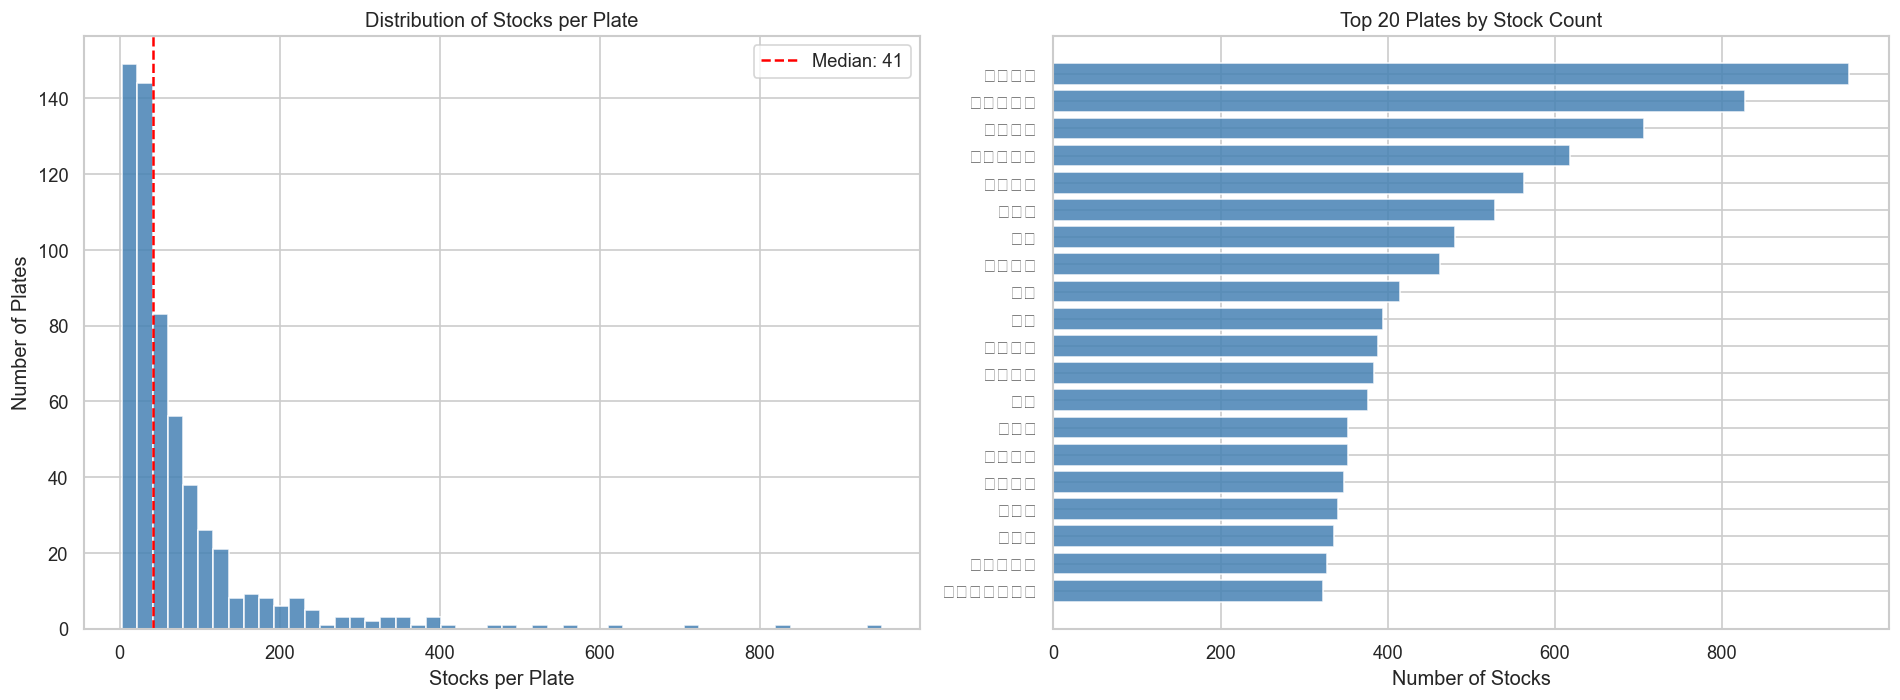


总计 589 个概念板块，43203 条个股-板块关联
平均每个板块 73.3 只个股


In [23]:
# ── 每个板块的个股数量分布 ──
stocks_per_plate = df_stocks.groupby("plate_id").size().reset_index(name="stock_count")
stocks_per_plate = stocks_per_plate.merge(df_plates[["id", "name"]], left_on="plate_id", right_on="id", how="left")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(stocks_per_plate["stock_count"], bins=50, color="steelblue", edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Stocks per Plate")
axes[0].set_ylabel("Number of Plates")
axes[0].set_title("Distribution of Stocks per Plate")
axes[0].axvline(stocks_per_plate["stock_count"].median(), color="red", linestyle="--",
                label=f'Median: {stocks_per_plate["stock_count"].median():.0f}')
axes[0].legend()

top20_stocks = stocks_per_plate.nlargest(20, "stock_count")
axes[1].barh(top20_stocks["name"], top20_stocks["stock_count"], color="steelblue", alpha=0.85)
axes[1].set_xlabel("Number of Stocks")
axes[1].set_title("Top 20 Plates by Stock Count")
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plate_stock_distribution.png"), bbox_inches="tight")
plt.show()

print(f"\n总计 {len(df_plates)} 个概念板块，{len(df_stocks)} 条个股-板块关联")
print(f"平均每个板块 {stocks_per_plate['stock_count'].mean():.1f} 只个股")

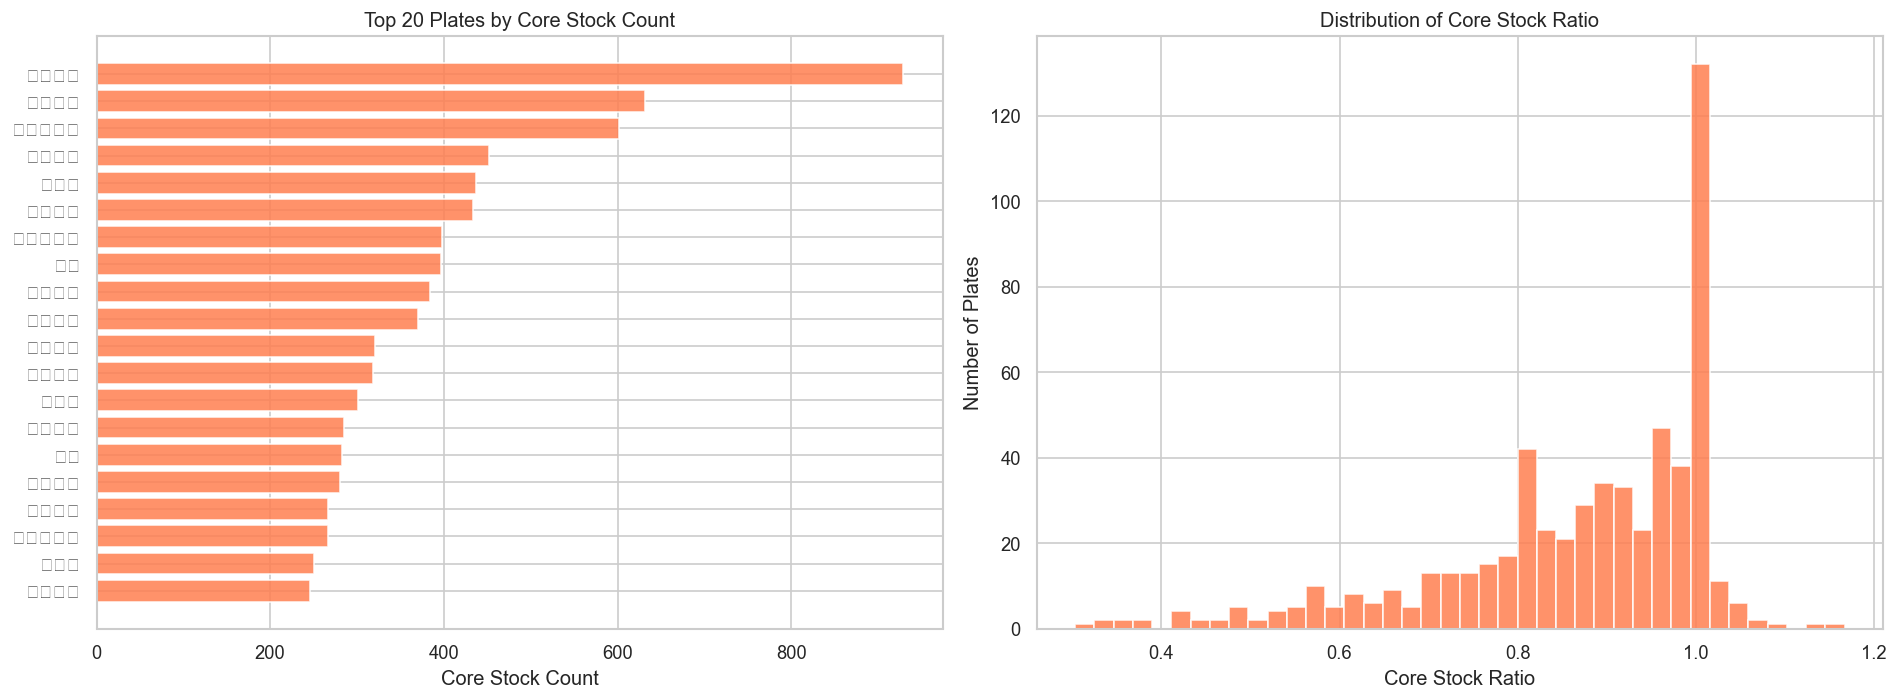

In [24]:
# ── 核心股数量分布 ──
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top20_core = df_plates.nlargest(20, "core_stocks_count")[["name", "core_stocks_count"]]
axes[0].barh(top20_core["name"], top20_core["core_stocks_count"], color="coral", alpha=0.85)
axes[0].set_xlabel("Core Stock Count")
axes[0].set_title("Top 20 Plates by Core Stock Count")
axes[0].invert_yaxis()

df_plates["core_ratio"] = df_plates["core_stocks_count"] / df_plates["total_stocks"].replace(0, np.nan)
valid = df_plates.dropna(subset=["core_ratio"])
axes[1].hist(valid["core_ratio"], bins=40, color="coral", edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Core Stock Ratio")
axes[1].set_ylabel("Number of Plates")
axes[1].set_title("Distribution of Core Stock Ratio")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "core_stocks_distribution.png"), bbox_inches="tight")
plt.show()

## 6. 概念股热度与关注度分析

以**资金净流入**作为板块热度的核心代理指标：资金大幅净流入通常意味着该概念受到市场高度关注。

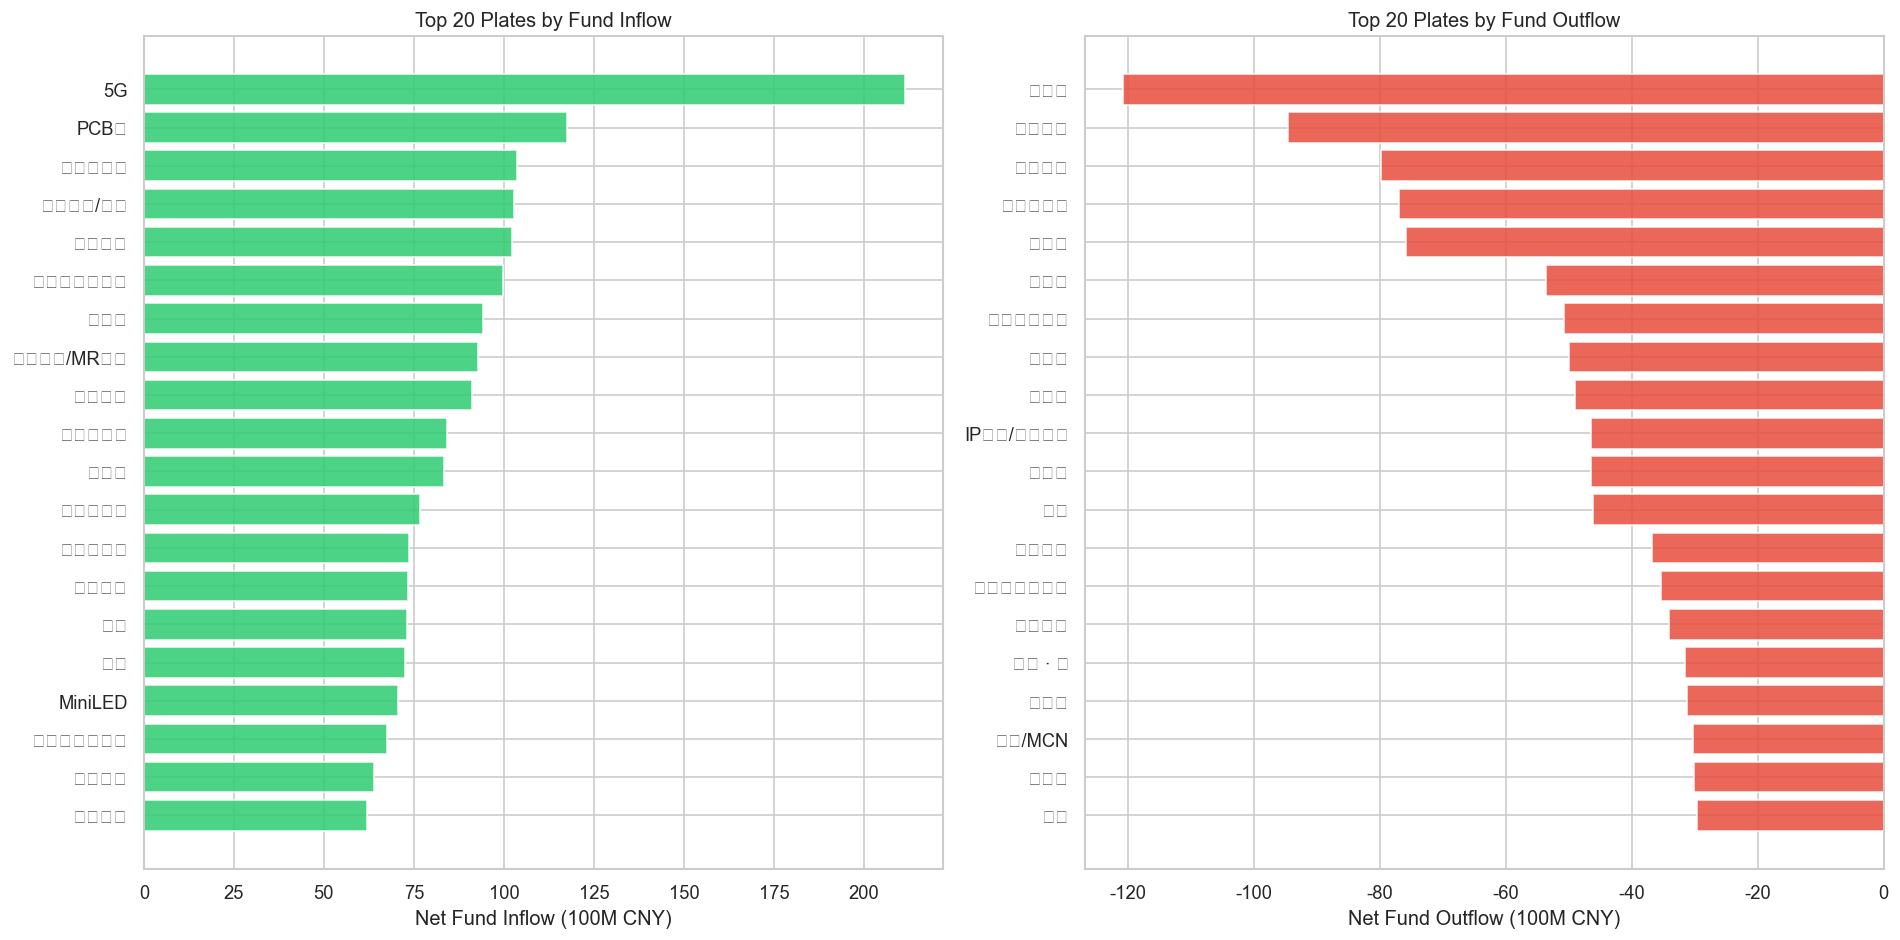

In [25]:
# ── 资金净流入 Top 20 & Bottom 20 ──
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top20_inflow = df_plates.nlargest(20, "fund_flow_yi")[["name", "fund_flow_yi"]]
colors_in = ["#2ecc71" if v > 0 else "#e74c3c" for v in top20_inflow["fund_flow_yi"]]
axes[0].barh(top20_inflow["name"], top20_inflow["fund_flow_yi"], color=colors_in, alpha=0.85)
axes[0].set_xlabel("Net Fund Inflow (100M CNY)")
axes[0].set_title("Top 20 Plates by Fund Inflow")
axes[0].invert_yaxis()
axes[0].axvline(0, color="gray", linewidth=0.5)

bot20_outflow = df_plates.nsmallest(20, "fund_flow_yi")[["name", "fund_flow_yi"]]
colors_out = ["#2ecc71" if v > 0 else "#e74c3c" for v in bot20_outflow["fund_flow_yi"]]
axes[1].barh(bot20_outflow["name"], bot20_outflow["fund_flow_yi"], color=colors_out, alpha=0.85)
axes[1].set_xlabel("Net Fund Outflow (100M CNY)")
axes[1].set_title("Top 20 Plates by Fund Outflow")
axes[1].invert_yaxis()
axes[1].axvline(0, color="gray", linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "fund_flow_top_bottom.png"), bbox_inches="tight")
plt.show()

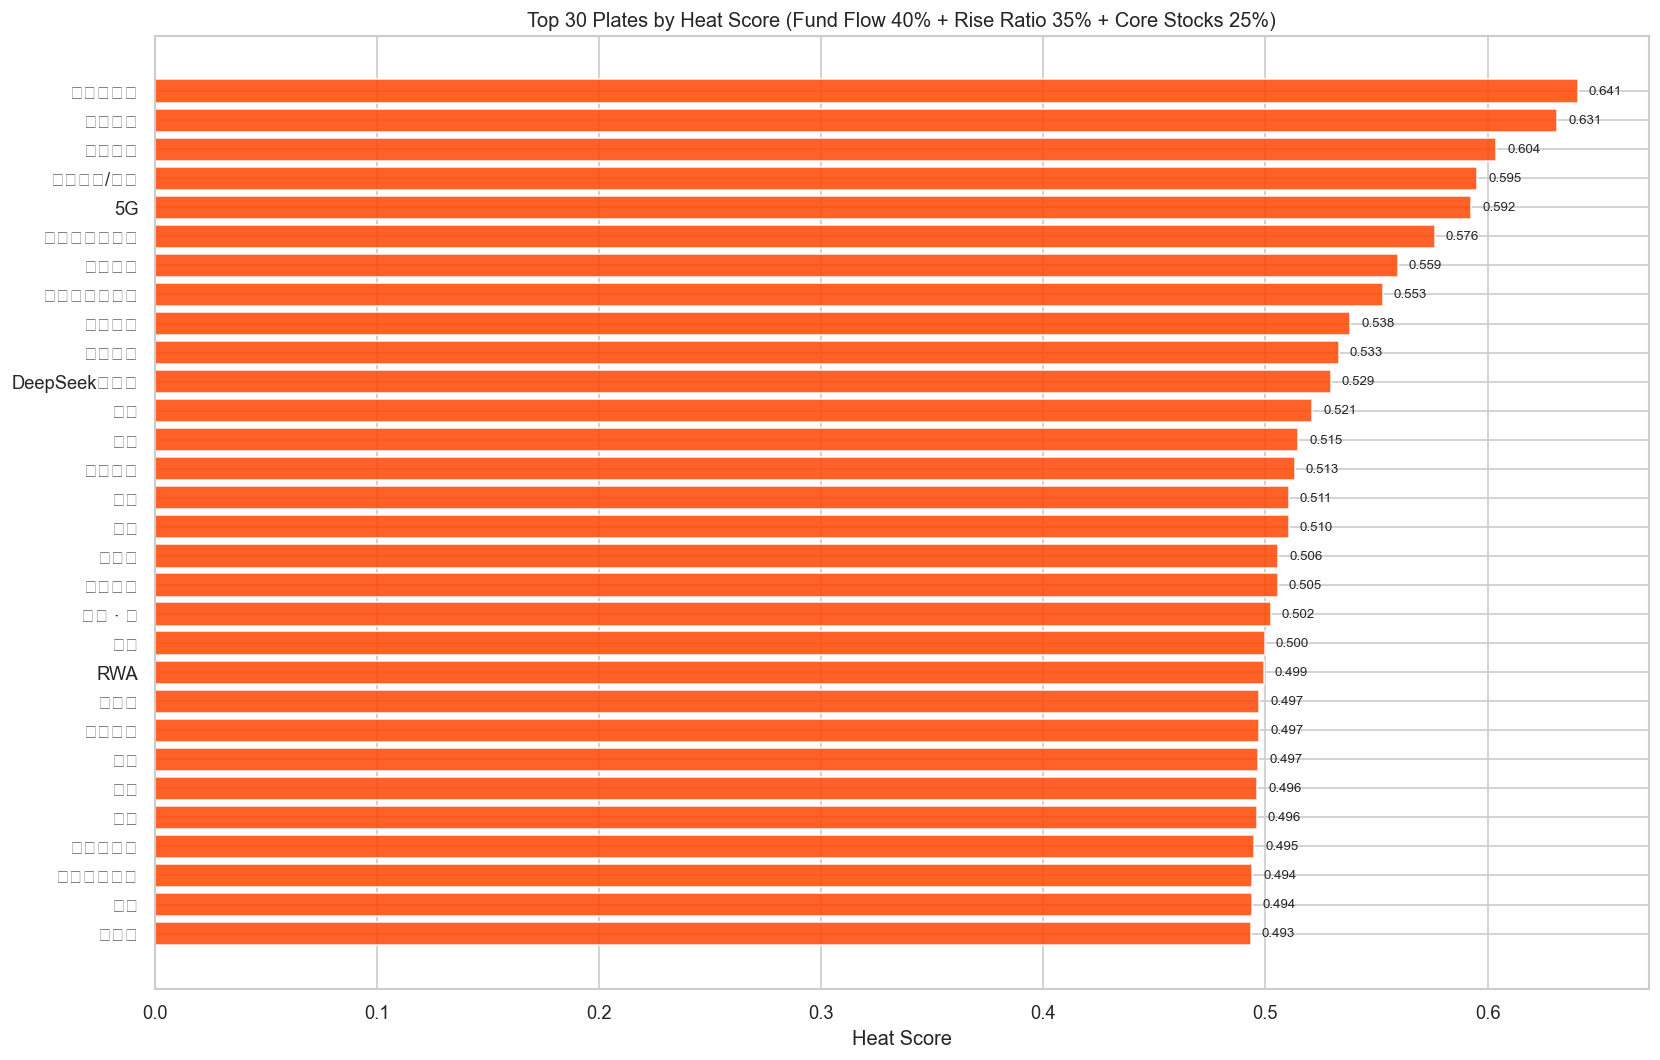

In [26]:
# ── 热度综合评分：资金流入 + 上涨比例 + 核心股数量 ──
from sklearn.preprocessing import MinMaxScaler

score_cols = ["fund_flow_yi", "rise_ratio", "core_stocks_count"]
df_score = df_plates[["id", "name"] + score_cols].dropna()
scaler = MinMaxScaler()
df_score[["s_fund", "s_rise", "s_core"]] = scaler.fit_transform(df_score[score_cols])
df_score["heat_score"] = df_score["s_fund"] * 0.4 + df_score["s_rise"] * 0.35 + df_score["s_core"] * 0.25

top30_heat = df_score.nlargest(30, "heat_score")

fig, ax = plt.subplots(figsize=(14, 9))
bars = ax.barh(top30_heat["name"], top30_heat["heat_score"], color="orangered", alpha=0.85)
ax.set_xlabel("Heat Score")
ax.set_title("Top 30 Plates by Heat Score (Fund Flow 40% + Rise Ratio 35% + Core Stocks 25%)")
ax.invert_yaxis()
for bar, score in zip(bars, top30_heat["heat_score"]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2,
            f"{score:.3f}", va="center", fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "heat_score_top30.png"), bbox_inches="tight")
plt.show()

## 7. 概念板块涨跌幅分析

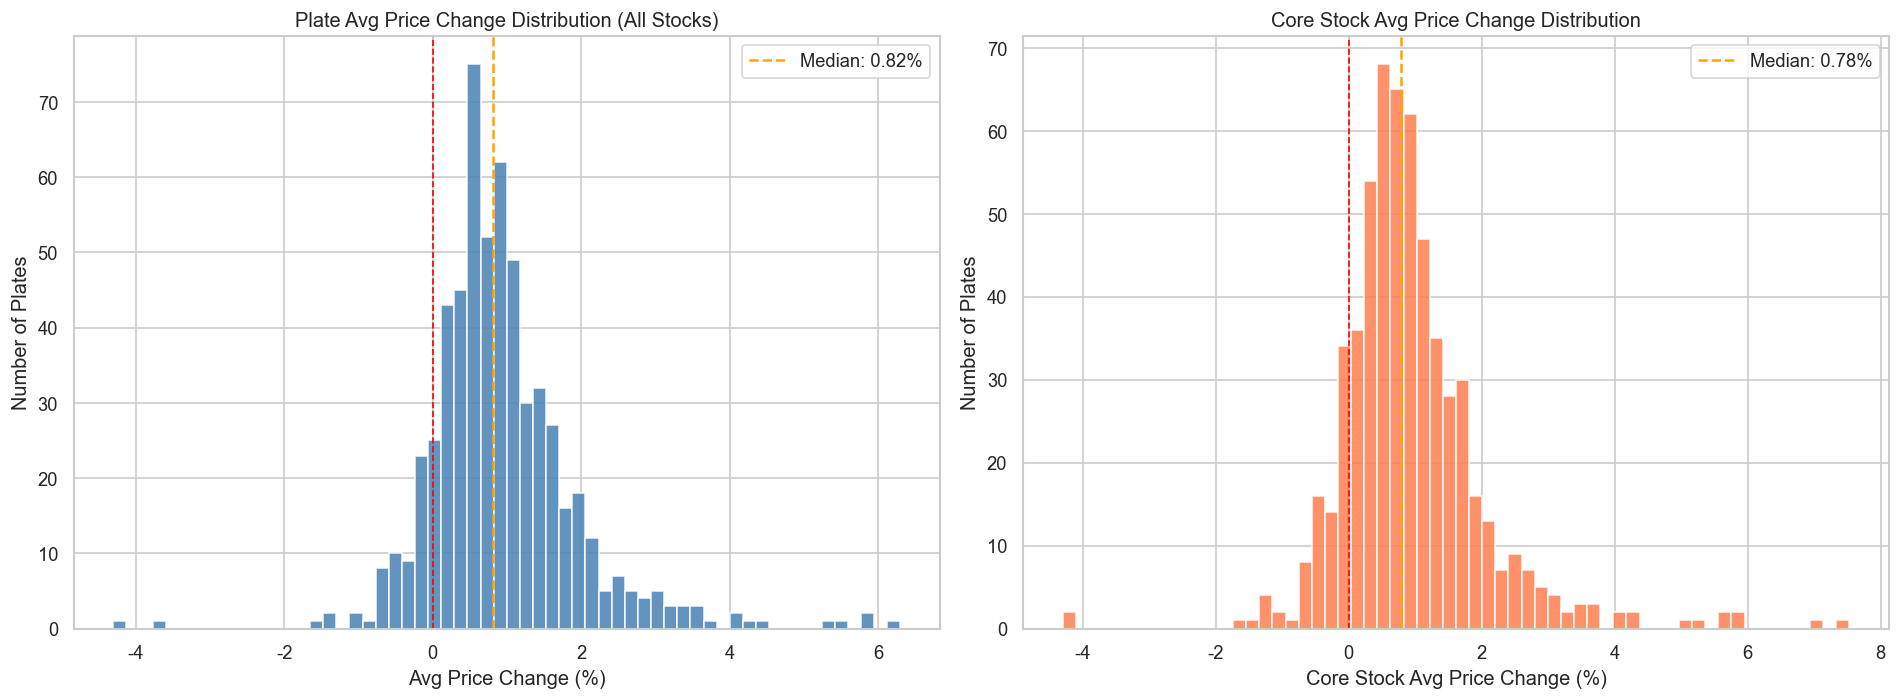

板块涨跌统计: 上涨 521 (88.5%) | 下跌 68 (11.5%) | 平盘 0


In [27]:
# ── 涨跌幅分布直方图 ──
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(df_plates["avg_pcp_pct"].dropna(), bins=60, color="steelblue", edgecolor="white", alpha=0.85)
axes[0].axvline(0, color="red", linestyle="--", linewidth=1)
axes[0].axvline(df_plates["avg_pcp_pct"].median(), color="orange", linestyle="--",
                label=f'Median: {df_plates["avg_pcp_pct"].median():.2f}%')
axes[0].set_xlabel("Avg Price Change (%)")
axes[0].set_ylabel("Number of Plates")
axes[0].set_title("Plate Avg Price Change Distribution (All Stocks)")
axes[0].legend()

axes[1].hist(df_plates["core_avg_pcp_pct"].dropna(), bins=60, color="coral", edgecolor="white", alpha=0.85)
axes[1].axvline(0, color="red", linestyle="--", linewidth=1)
axes[1].axvline(df_plates["core_avg_pcp_pct"].median(), color="orange", linestyle="--",
                label=f'Median: {df_plates["core_avg_pcp_pct"].median():.2f}%')
axes[1].set_xlabel("Core Stock Avg Price Change (%)")
axes[1].set_ylabel("Number of Plates")
axes[1].set_title("Core Stock Avg Price Change Distribution")
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pcp_distribution.png"), bbox_inches="tight")
plt.show()

up = (df_plates["avg_pcp_pct"] > 0).sum()
down = (df_plates["avg_pcp_pct"] < 0).sum()
flat = (df_plates["avg_pcp_pct"] == 0).sum()
print(f"板块涨跌统计: 上涨 {up} ({up/len(df_plates)*100:.1f}%) | "
      f"下跌 {down} ({down/len(df_plates)*100:.1f}%) | 平盘 {flat}")

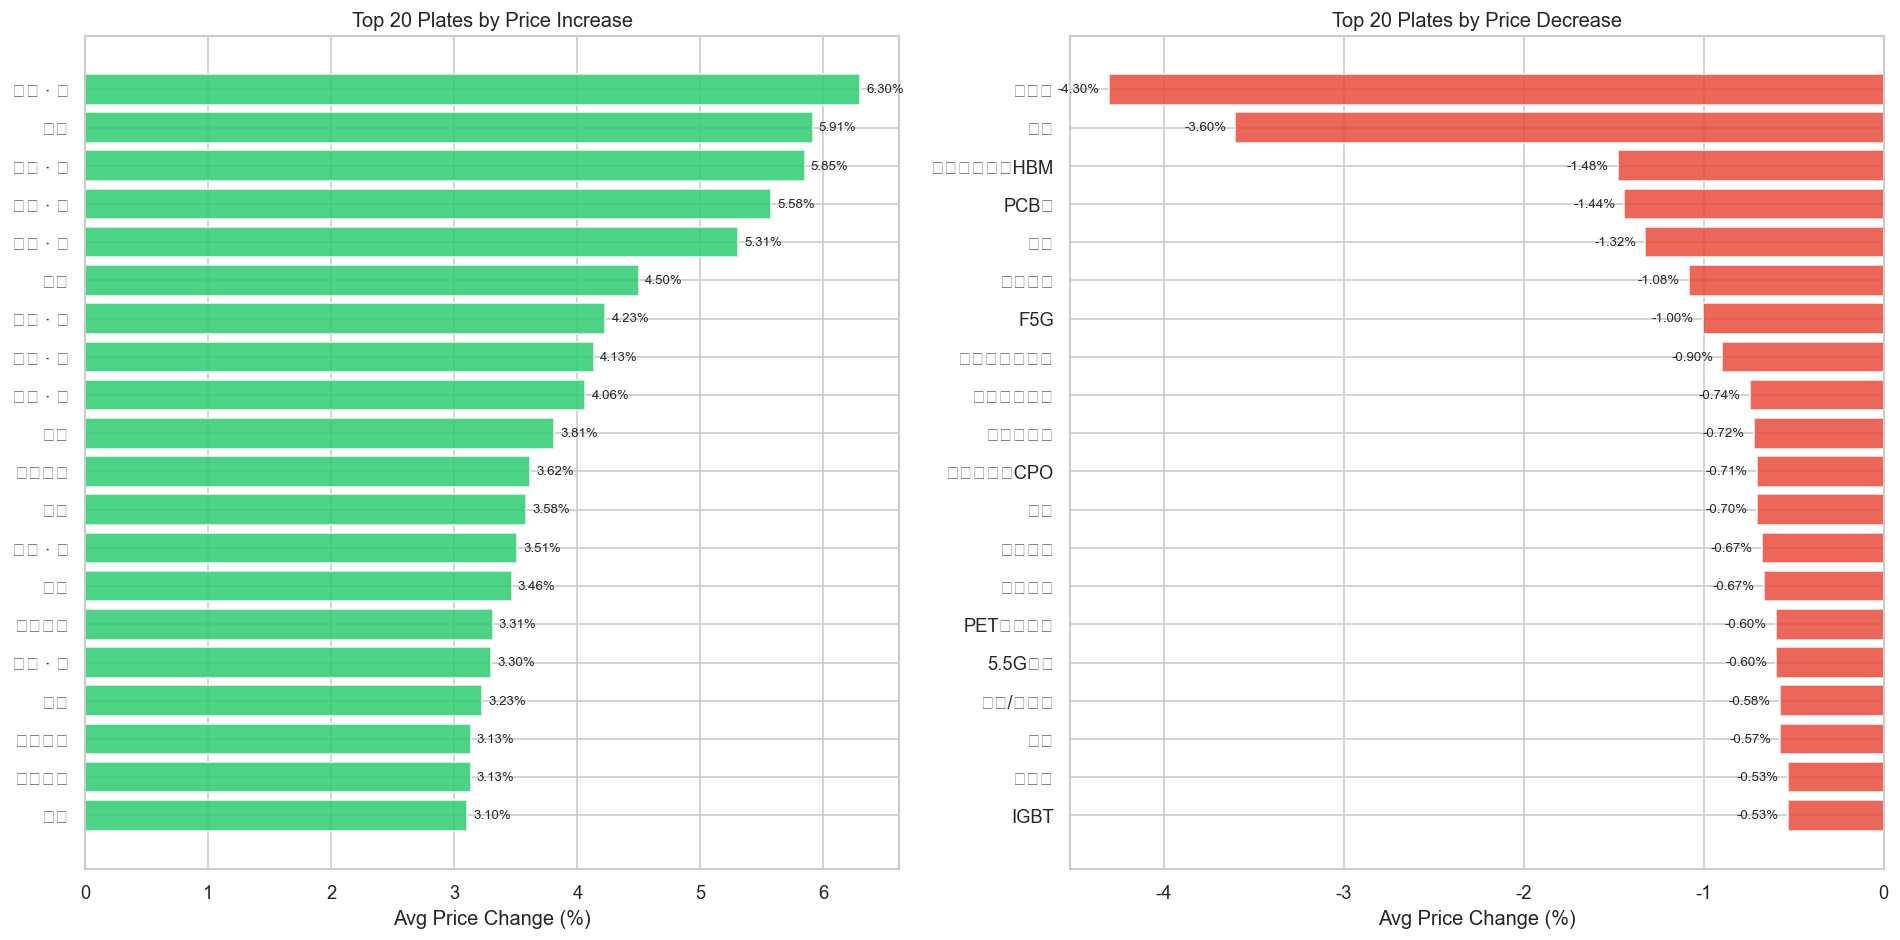

In [28]:
# ── 涨幅 Top 20 vs 跌幅 Top 20 ──
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top20_rise = df_plates.nlargest(20, "avg_pcp_pct")[["name", "avg_pcp_pct"]]
top20_fall = df_plates.nsmallest(20, "avg_pcp_pct")[["name", "avg_pcp_pct"]]

axes[0].barh(top20_rise["name"], top20_rise["avg_pcp_pct"], color="#2ecc71", alpha=0.85)
axes[0].set_xlabel("Avg Price Change (%)")
axes[0].set_title("Top 20 Plates by Price Increase")
axes[0].invert_yaxis()
for i, (_, row) in enumerate(top20_rise.iterrows()):
    axes[0].text(row["avg_pcp_pct"] + 0.05, i, f'{row["avg_pcp_pct"]:.2f}%', va="center", fontsize=8)

axes[1].barh(top20_fall["name"], top20_fall["avg_pcp_pct"], color="#e74c3c", alpha=0.85)
axes[1].set_xlabel("Avg Price Change (%)")
axes[1].set_title("Top 20 Plates by Price Decrease")
axes[1].invert_yaxis()
for i, (_, row) in enumerate(top20_fall.iterrows()):
    axes[1].text(row["avg_pcp_pct"] - 0.05, i, f'{row["avg_pcp_pct"]:.2f}%', va="center", ha="right", fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pcp_top_bottom.png"), bbox_inches="tight")
plt.show()

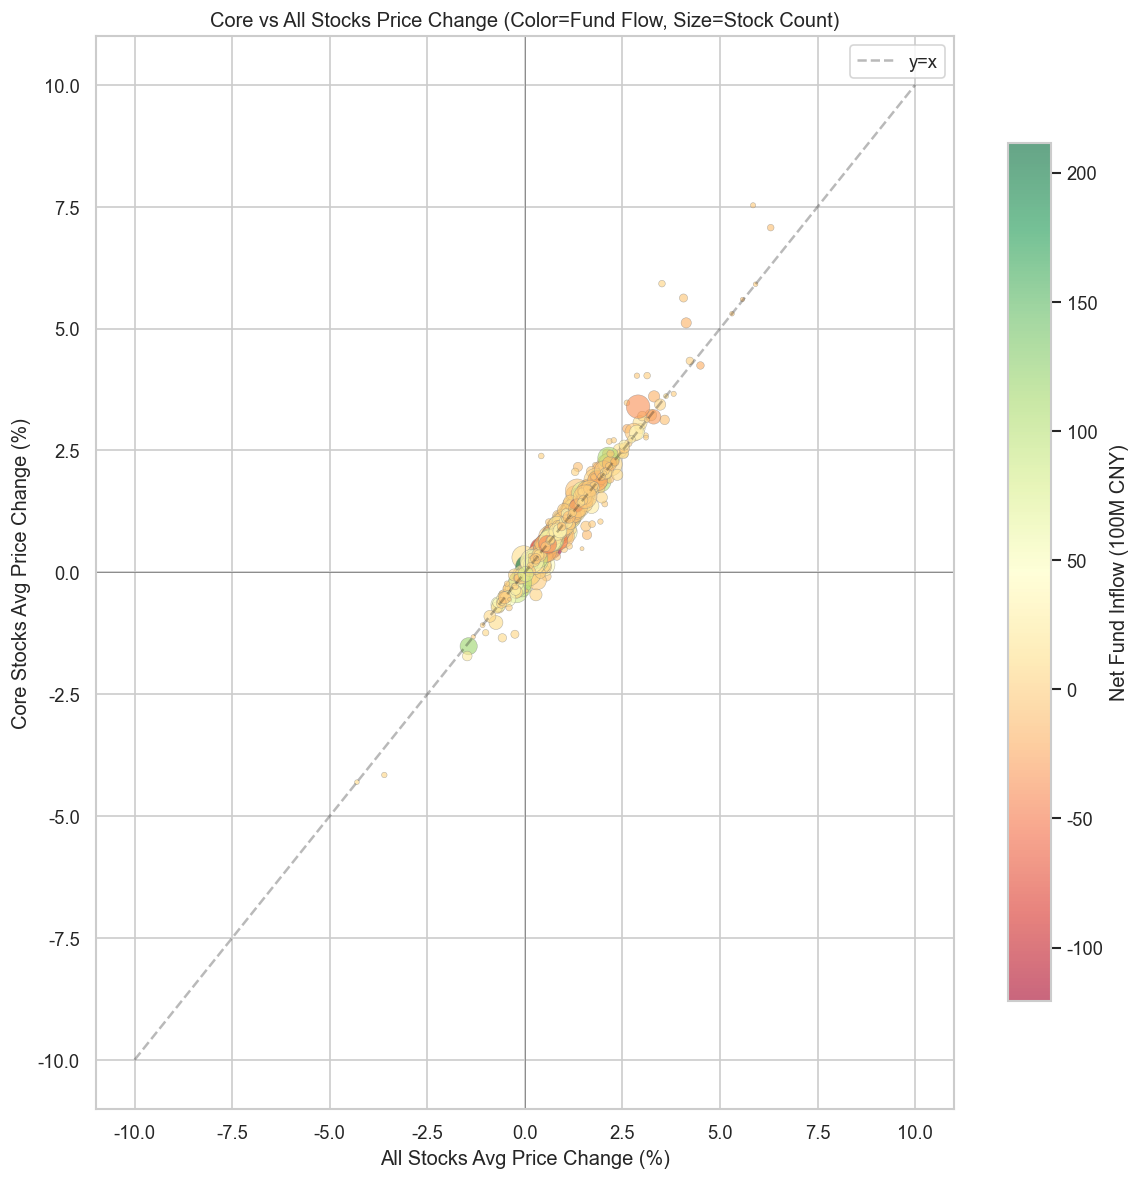

In [29]:
# ── 核心股涨跌 vs 全股涨跌 散点图 ──
fig, ax = plt.subplots(figsize=(10, 10))
valid = df_plates.dropna(subset=["avg_pcp_pct", "core_avg_pcp_pct"])

scatter = ax.scatter(
    valid["avg_pcp_pct"], valid["core_avg_pcp_pct"],
    c=valid["fund_flow_yi"], cmap="RdYlGn", s=valid["total_stocks"].clip(5, 200),
    alpha=0.6, edgecolors="gray", linewidths=0.3,
)
ax.plot([-10, 10], [-10, 10], "k--", alpha=0.3, label="y=x")
ax.axhline(0, color="gray", linewidth=0.5)
ax.axvline(0, color="gray", linewidth=0.5)
ax.set_xlabel("All Stocks Avg Price Change (%)")
ax.set_ylabel("Core Stocks Avg Price Change (%)")
ax.set_title("Core vs All Stocks Price Change (Color=Fund Flow, Size=Stock Count)")
ax.legend()
plt.colorbar(scatter, ax=ax, label="Net Fund Inflow (100M CNY)", shrink=0.8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "core_vs_all_scatter.png"), bbox_inches="tight")
plt.show()

## 8. 概念股关联性分析（个股与多概念的映射）

分析哪些个股横跨最多的概念板块——这些"多概念交叉股"往往是市场关注度和弹性最高的标的。

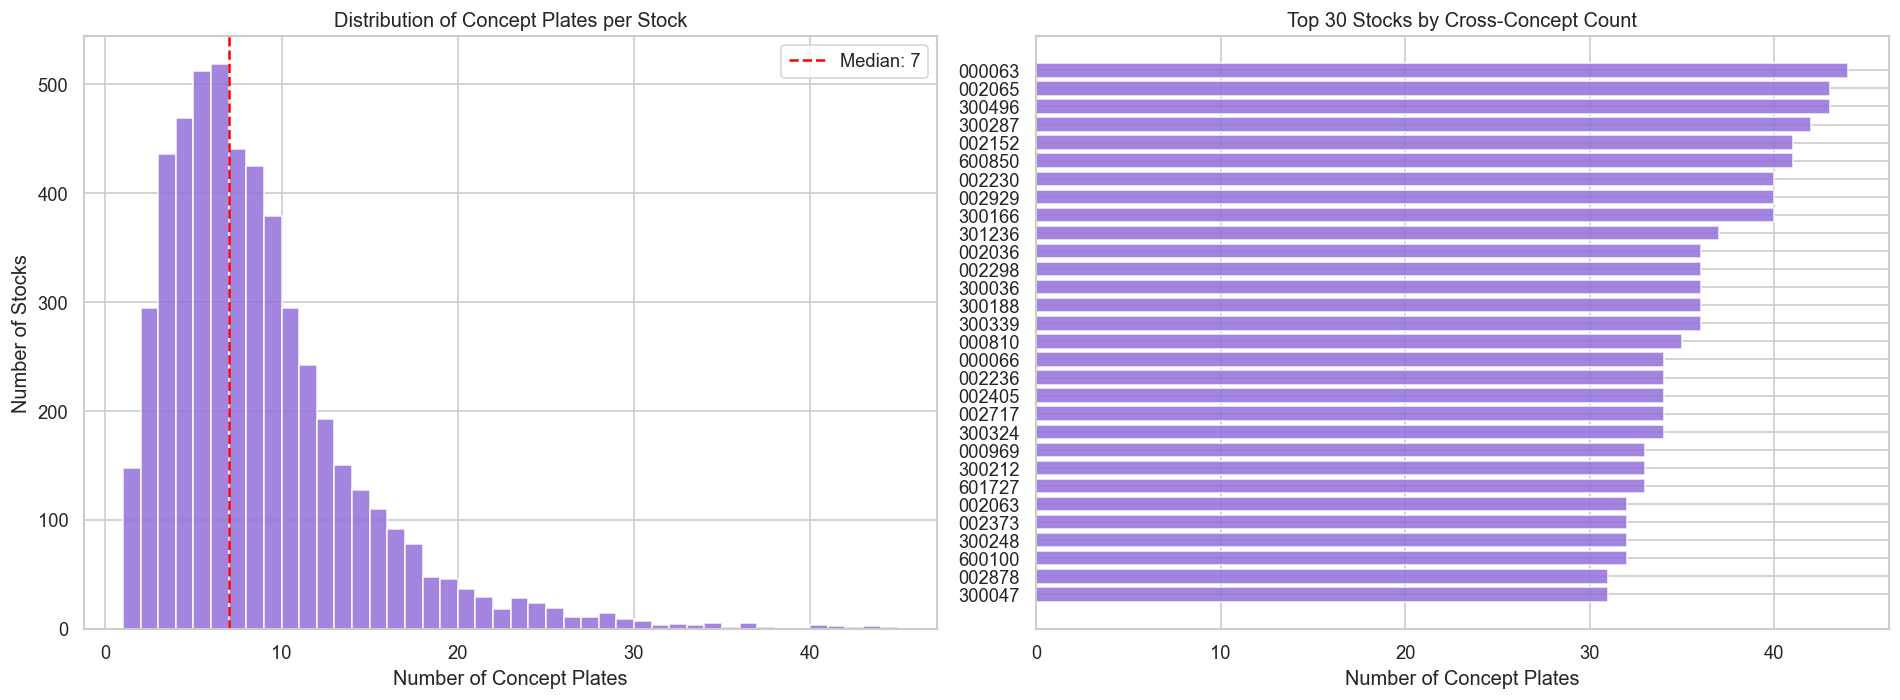


独立个股数: 5232
最多跨概念数: 44
平均跨概念数: 8.3


In [30]:
# ── 个股所属概念板块数量分布 ──
plates_per_stock = df_stocks.groupby("symbol")["plate_id"].nunique().reset_index(name="plate_count")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(plates_per_stock["plate_count"], bins=range(1, plates_per_stock["plate_count"].max() + 2),
             color="mediumpurple", edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Number of Concept Plates")
axes[0].set_ylabel("Number of Stocks")
axes[0].set_title("Distribution of Concept Plates per Stock")
axes[0].axvline(plates_per_stock["plate_count"].median(), color="red", linestyle="--",
                label=f'Median: {plates_per_stock["plate_count"].median():.0f}')
axes[0].legend()

top30_cross = plates_per_stock.nlargest(30, "plate_count")
axes[1].barh(top30_cross["symbol"], top30_cross["plate_count"], color="mediumpurple", alpha=0.85)
axes[1].set_xlabel("Number of Concept Plates")
axes[1].set_title("Top 30 Stocks by Cross-Concept Count")
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "stock_cross_concepts.png"), bbox_inches="tight")
plt.show()

print(f"\n独立个股数: {plates_per_stock.shape[0]}")
print(f"最多跨概念数: {plates_per_stock['plate_count'].max()}")
print(f"平均跨概念数: {plates_per_stock['plate_count'].mean():.1f}")

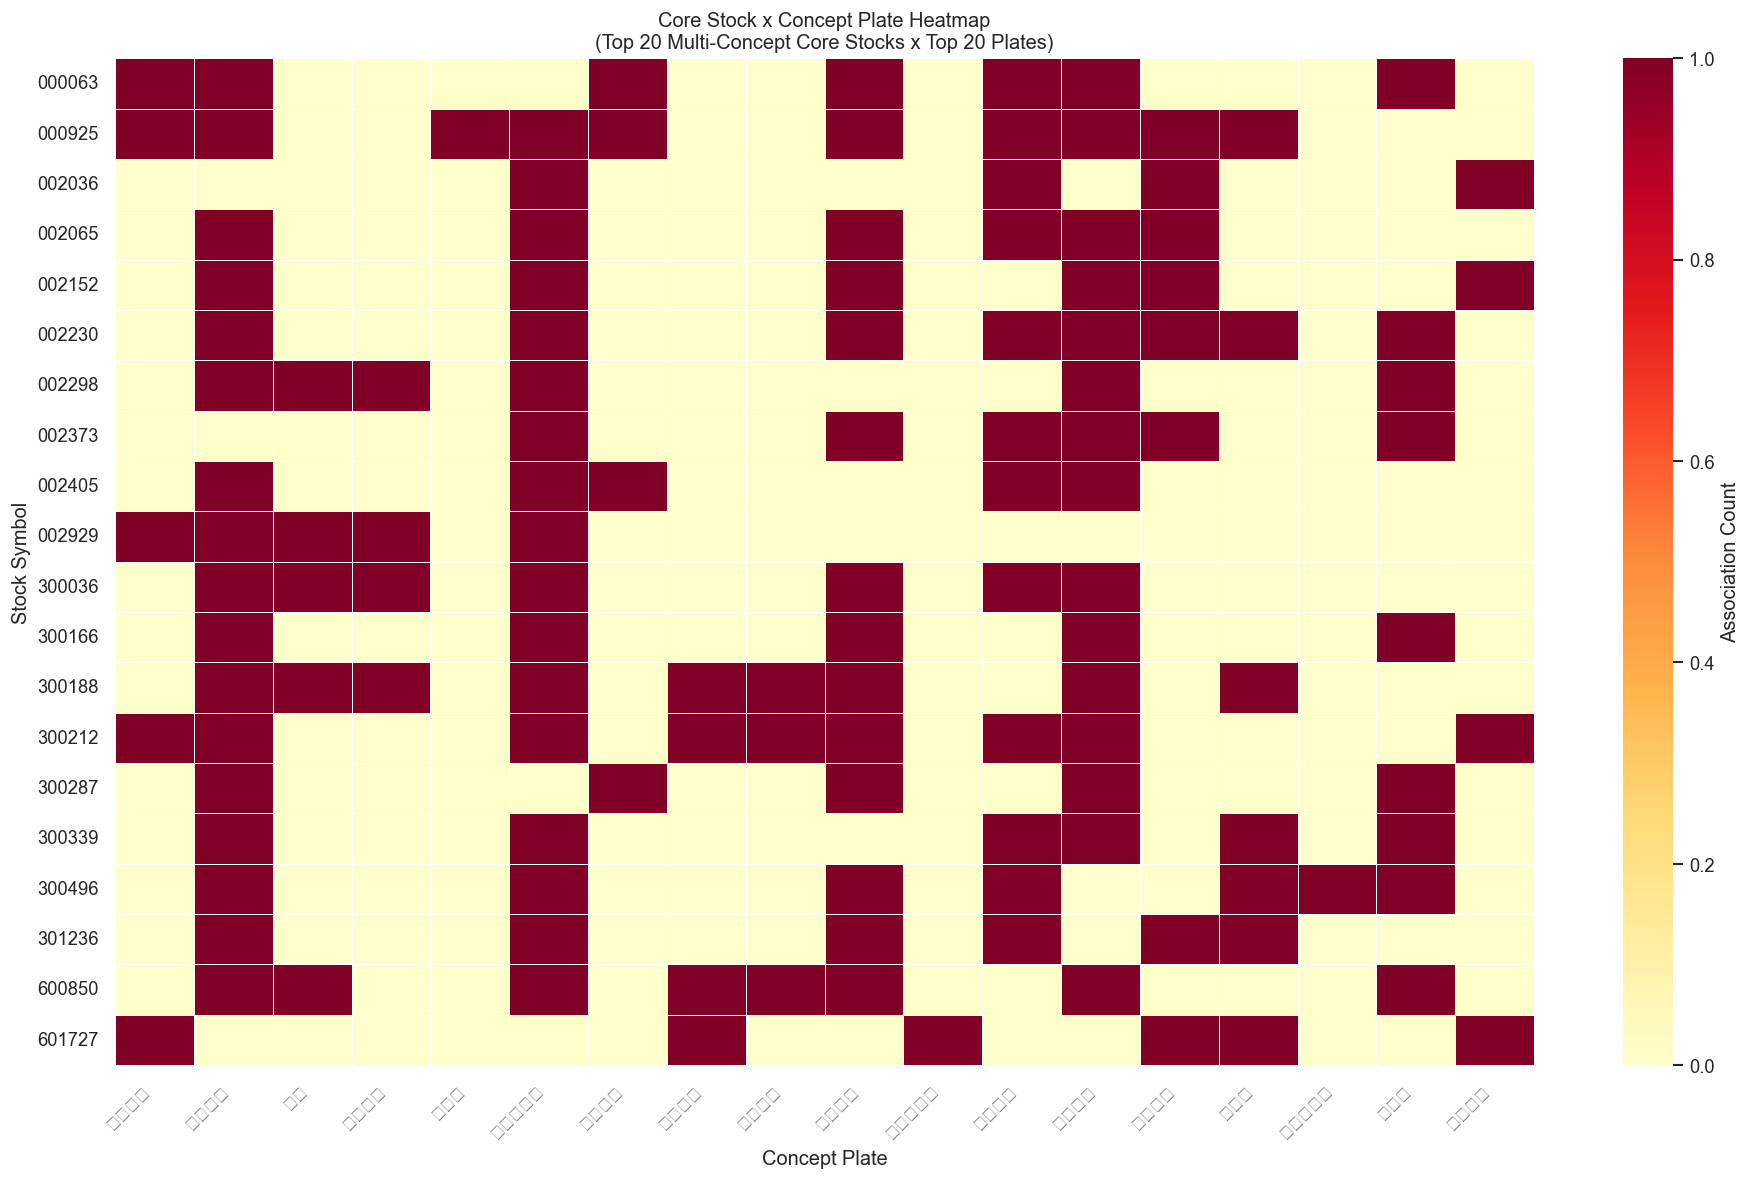

In [31]:
# ── 核心股 × 概念板块 的交叉热力图（取 Top 20 概念 & Top 20 多概念核心股）──
core_stocks = df_stocks[df_stocks["core_flag"] == 100].copy()
core_plates = core_stocks.merge(df_plates[["id", "name"]], left_on="plate_id", right_on="id", how="left")

core_cross = core_plates.groupby("symbol")["name"].nunique().nlargest(20).index
top_plates = core_plates["name"].value_counts().nlargest(20).index

matrix_data = core_plates[
    core_plates["symbol"].isin(core_cross) & core_plates["name"].isin(top_plates)
]
cross_matrix = pd.crosstab(matrix_data["symbol"], matrix_data["name"])

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(cross_matrix, cmap="YlOrRd", linewidths=0.5, linecolor="white",
            cbar_kws={"label": "Association Count"}, ax=ax)
ax.set_title("Core Stock x Concept Plate Heatmap\n(Top 20 Multi-Concept Core Stocks x Top 20 Plates)")
ax.set_xlabel("Concept Plate")
ax.set_ylabel("Stock Symbol")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "core_stock_concept_heatmap.png"), bbox_inches="tight")
plt.show()

## 9. 产业链结构分析

分析板块的产业链环节丰富度，找出产业链覆盖最全面的概念板块。

In [32]:
# ── 产业链环节统计 ──
chains_with_names = df_chains.merge(df_plates[["id", "name"]], left_on="plate_id", right_on="id", how="left")
chains_per_plate = chains_with_names.groupby(["plate_id", "name"]).size().reset_index(name="chain_count")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].hist(chains_per_plate["chain_count"], bins=range(1, chains_per_plate["chain_count"].max() + 2),
             color="teal", edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Chain Segment Count")
axes[0].set_ylabel("Number of Plates")
axes[0].set_title("Distribution of Chain Segments per Plate")

top20_chains = chains_per_plate.nlargest(20, "chain_count")
axes[1].barh(top20_chains["name"], top20_chains["chain_count"], color="teal", alpha=0.85)
axes[1].set_xlabel("Chain Segment Count")
axes[1].set_title("Top 20 Plates by Chain Segment Count")
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "chain_distribution.png"), bbox_inches="tight")
plt.show()

print("\n产业链最丰富的 5 个板块详情：")
for _, row in top20_chains.head(5).iterrows():
    chain_names = df_chains[df_chains["plate_id"] == row["plate_id"]]["name"].tolist()
    print(f"\n  {row['name']} ({row['chain_count']} segments): {', '.join(chain_names)}")

KeyError: 'name'

## 10. 概念板块龙头股筛选

筛选逻辑：
- **核心股**（`core_flag == 100`）作为候选
- 多维度评分：所属板块涨幅、资金流入、跨概念数量
- 综合加权排名输出

In [ ]:
# ── 龙头股综合评分 ──
# Step 1: 核心股 + 板块信息
core_full = df_stocks[df_stocks["core_flag"] == 100].merge(
    df_plates[["id", "name", "avg_pcp_pct", "fund_flow_yi", "core_stocks_count"]],
    left_on="plate_id", right_on="id", how="left",
)

# Step 2: 每只核心股在所有板块中的加权得分
# - 所属板块平均涨幅（越高越好）
# - 所属板块资金流入（越高越好）
# - 跨概念数量（越多越好）
stock_agg = core_full.groupby("symbol").agg(
    plate_count=("plate_id", "nunique"),
    avg_plate_pcp=("avg_pcp_pct", "mean"),
    total_fund_flow=("fund_flow_yi", "sum"),
    plates=("name", lambda x: ", ".join(sorted(set(x))[:5])),  # 前5个板块名
).reset_index()

# Step 3: MinMaxScaler 归一化 + 加权
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
score_features = ["plate_count", "avg_plate_pcp", "total_fund_flow"]
stock_agg[["s_cross", "s_pcp", "s_fund"]] = scaler.fit_transform(stock_agg[score_features])
stock_agg["leader_score"] = stock_agg["s_cross"] * 0.3 + stock_agg["s_pcp"] * 0.4 + stock_agg["s_fund"] * 0.3

# Step 4: 排名输出
top50_leaders = stock_agg.nlargest(50, "leader_score")

print("=" * 80)
print("概念板块龙头股 Top 50 综合评分")
print("评分权重: 板块涨幅 40% + 资金流入 30% + 跨概念数 30%")
print("=" * 80)
display(top50_leaders[["symbol", "leader_score", "plate_count", "avg_plate_pcp", "total_fund_flow", "plates"]].reset_index(drop=True))

In [ ]:
# ── 龙头股评分可视化 ──
fig, ax = plt.subplots(figsize=(14, 12))
top30_vis = top50_leaders.head(30)

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.95, len(top30_vis)))
bars = ax.barh(top30_vis["symbol"], top30_vis["leader_score"], color=colors, alpha=0.9)
ax.set_xlabel("Leader Stock Composite Score")
ax.set_title("Top 30 Leader Stocks Composite Score\n(Plate PCP 40% + Fund Flow 30% + Cross-Concept 30%)")
ax.invert_yaxis()

for bar, (_, row) in zip(bars, top30_vis.iterrows()):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2,
            f'{row["leader_score"]:.3f} | {row["plate_count"]} concepts',
            va="center", fontsize=7, color="gray")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "leader_stocks_top30.png"), bbox_inches="tight")
plt.show()

## 11. 数据可视化仪表盘汇总

将核心分析结果整合为 2×3 多图仪表盘。

In [ ]:
# ── 仪表盘：2×3 汇总 ──
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle("Xuangubao Concept Stock Analysis Dashboard", fontsize=18, fontweight="bold", y=1.01)

# ─── (0,0) Plate Avg Price Change Distribution ───
axes[0, 0].hist(df_plates["avg_pcp_pct"].dropna(), bins=50, color="steelblue", edgecolor="white", alpha=0.85)
axes[0, 0].axvline(0, color="red", linestyle="--", linewidth=1)
axes[0, 0].set_title("Plate Avg Price Change Distribution")
axes[0, 0].set_xlabel("Price Change (%)")

# ─── (0,1) Fund Inflow Top 10 ───
top10_fund = df_plates.nlargest(10, "fund_flow_yi")[["name", "fund_flow_yi"]]
c = ["#2ecc71" if v > 0 else "#e74c3c" for v in top10_fund["fund_flow_yi"]]
axes[0, 1].barh(top10_fund["name"], top10_fund["fund_flow_yi"], color=c, alpha=0.85)
axes[0, 1].set_title("Net Fund Inflow Top 10")
axes[0, 1].set_xlabel("100M CNY")
axes[0, 1].invert_yaxis()

# ─── (0,2) Price Increase Top 10 ───
top10_rise = df_plates.nlargest(10, "avg_pcp_pct")[["name", "avg_pcp_pct"]]
axes[0, 2].barh(top10_rise["name"], top10_rise["avg_pcp_pct"], color="#2ecc71", alpha=0.85)
axes[0, 2].set_title("Price Increase Top 10")
axes[0, 2].set_xlabel("Price Change (%)")
axes[0, 2].invert_yaxis()

# ─── (1,0) Cross-Concept Distribution ───
axes[1, 0].hist(plates_per_stock["plate_count"], bins=range(1, 30),
                color="mediumpurple", edgecolor="white", alpha=0.85)
axes[1, 0].set_title("Stock Cross-Concept Distribution")
axes[1, 0].set_xlabel("Number of Plates")

# ─── (1,1) Core vs All Stocks Scatter ───
valid = df_plates.dropna(subset=["avg_pcp_pct", "core_avg_pcp_pct"])
axes[1, 1].scatter(valid["avg_pcp_pct"], valid["core_avg_pcp_pct"],
                   c=valid["fund_flow_yi"], cmap="RdYlGn", s=30, alpha=0.5, edgecolors="gray", linewidths=0.3)
axes[1, 1].plot([-8, 8], [-8, 8], "k--", alpha=0.3)
axes[1, 1].set_title("Core vs All Stocks PCP")
axes[1, 1].set_xlabel("All Stocks PCP (%)")
axes[1, 1].set_ylabel("Core Stocks PCP (%)")

# ─── (1,2) Leader Stocks Top 10 ───
top10_leaders = top50_leaders.head(10)
colors_ld = plt.cm.RdYlGn(np.linspace(0.4, 0.95, len(top10_leaders)))
axes[1, 2].barh(top10_leaders["symbol"], top10_leaders["leader_score"], color=colors_ld, alpha=0.9)
axes[1, 2].set_title("Leader Stocks Top 10")
axes[1, 2].set_xlabel("Composite Score")
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "dashboard.png"), bbox_inches="tight", dpi=150)
plt.show()
print("Dashboard saved ✓")

## 12. 分析结果导出与保存

In [ ]:
# ── 导出分析结果 ──

# 1. 板块汇总表
plates_export = df_plates[[
    "id", "name", "desc", "avg_pcp_pct", "core_avg_pcp_pct",
    "fund_flow_yi", "rise_count", "fall_count", "stay_count",
    "total_stocks", "core_stocks_count", "rise_ratio", "updated_at",
]].sort_values("fund_flow_yi", ascending=False)
plates_export.to_csv(os.path.join(OUTPUT_DIR, "plates_summary.csv"), index=False, encoding="utf-8-sig")

# 2. 龙头股排名
top50_leaders.to_csv(os.path.join(OUTPUT_DIR, "leader_stocks_top50.csv"), index=False, encoding="utf-8-sig")

# 3. 个股跨概念统计
plates_per_stock_export = plates_per_stock.sort_values("plate_count", ascending=False)
plates_per_stock_export.to_csv(os.path.join(OUTPUT_DIR, "stock_cross_concepts.csv"), index=False, encoding="utf-8-sig")

# 4. 热度评分
if 'df_score' in dir():
    df_score.sort_values("heat_score", ascending=False).to_csv(
        os.path.join(OUTPUT_DIR, "plate_heat_score.csv"), index=False, encoding="utf-8-sig"
    )

# 关闭数据库连接
conn.close()

# 列出输出文件
print("=" * 60)
print("分析结果已导出到:", OUTPUT_DIR)
print("=" * 60)
for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f))
    print(f"  {f:45s} {size/1024:>8.1f} KB")
print(f"\n共 {len(os.listdir(OUTPUT_DIR))} 个文件")
print("分析完成 ✓")